# Load dataset

In [1]:

%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

In [2]:
def load_mnist(path, kind='train'):
    import os
    import struct
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        struct.unpack('>II', lbpath.read(8))
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8)

    with gzip.open(images_path, 'rb') as imgpath:
        struct.unpack(">IIII", imgpath.read(16))
        images = np.frombuffer(imgpath.read(), dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

In [3]:
X_train, y_train = load_mnist('data/fashion', kind='train')
X_test, y_test = load_mnist('data/fashion', kind='t10k')
y_train,y_test = y_train.astype(np.int64),y_test.astype(np.int64)
print('Training set size: {}'.format(X_train.shape))
print('Testing set size: {}'.format(X_test.shape))

Training set size: (60000, 784)
Testing set size: (10000, 784)


In [4]:
from matplotlib import pyplot as plt,cm
def show_img(im,figsize=None,ax=None,cmap=cm.binary):
    if not ax: fig,ax = plt.subplots(figsize = figsize)
    ax.imshow(im,cmap=cmap)
    return ax

In [5]:
X_train = X_train.reshape([-1,28,28])
X_test = X_test.reshape([-1,28,28])

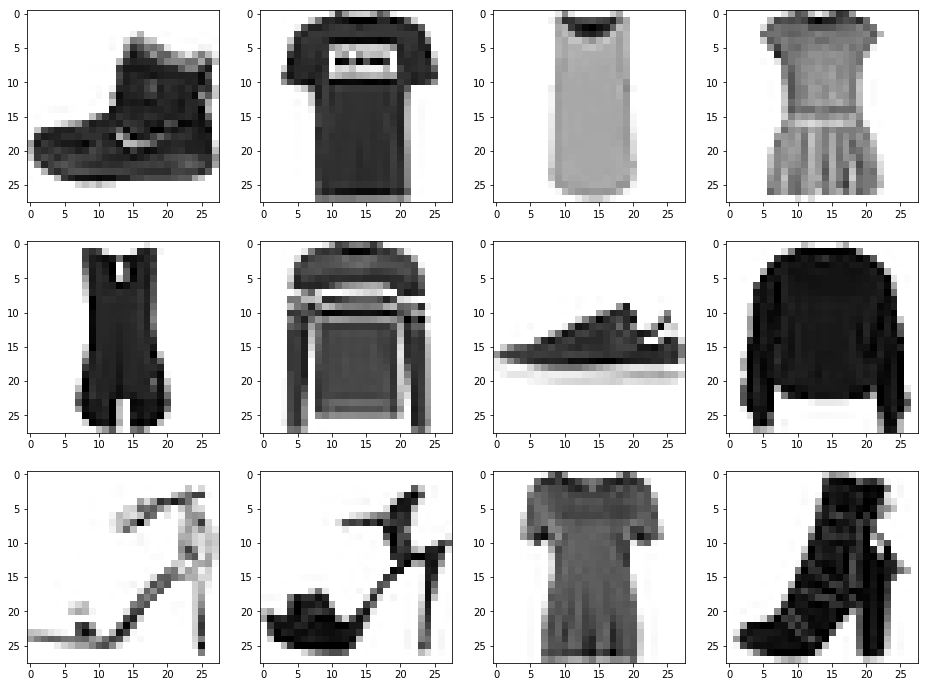

In [6]:
fig,axes=plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    _=show_img(X_train[i],ax=ax)

# Custom FashionMNIST data loader

Pytorch model expects data in minibatches and in torch tensors. We will use pytorch's DataLoader to do this

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
#To download the dataset for torchvision
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms


In [7]:
labels={
    0:'T-shirt/top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankle boot',
}

In [8]:
# custom dataset
class FMNIST(Dataset):
    def __init__(self,X,y,transforms=None):
        self.X = X[:,:,:,None] # n,28,28 to n,28,28,1
        self.y = y
        self.n = len(X)
        self.transforms = transforms
    
    def __getitem__(self,index):
        img = self.X[index]
        label = self.y[index]
        if self.transforms is not None:
            img = self.transforms(img)
        return (img,label)
    
    def __len__(self):
        return self.n
tsfms = transforms.ToTensor() # convert numpy to tensor

In [9]:
train_ds = FMNIST(X_train,y_train,tsfms)
train_dl = DataLoader(train_ds,batch_size=12,shuffle=True,num_workers=0)

In [10]:
X,y=next(iter(train_dl))
X=X.numpy()
y=y.numpy()

In [11]:
print(X.shape)
print(y.shape)

(12, 1, 28, 28)
(12,)


In [23]:
X[0][0][:5][:5]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00392157, 0.        , 0.        ,
        0.06666667, 0.11372549, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.01960784, 0.14509805, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.6       ,
        0.7882353 , 0.7882353 , 0.90588236, 0.61960787, 0.43137255,
        0.70980394, 0.8156863 , 0.76862746, 0.8       , 0.6745098 ,
        0.09803922, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.21568628, 0.85490197,
        0.73333335, 0.7372549 , 0.7647059 , 0.79607844, 0.8       ,
        0.8117647 , 0.7960

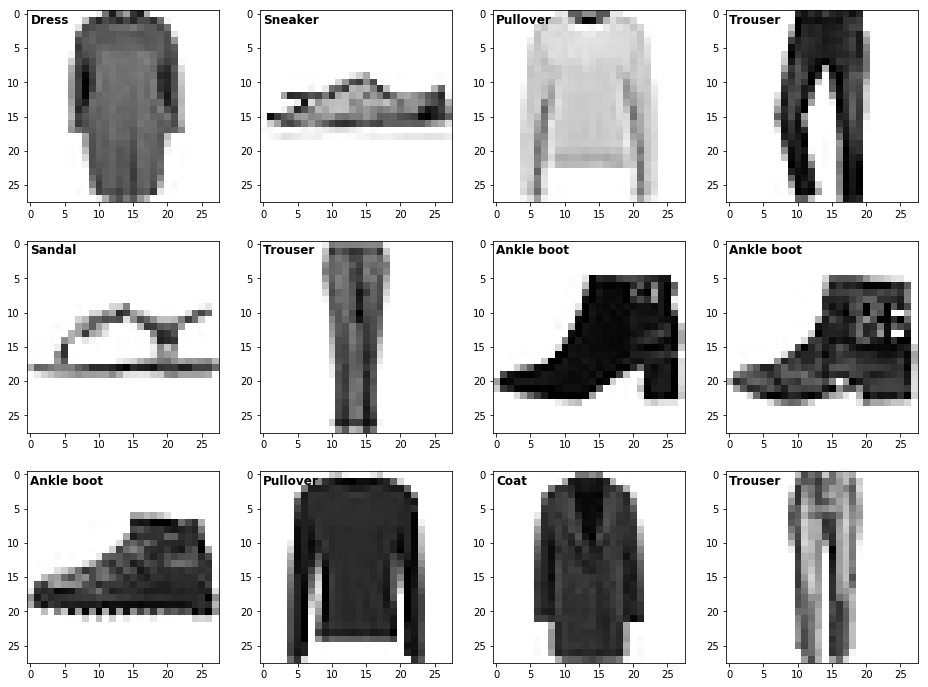

In [12]:
fig,axes=plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    ax=show_img(np.squeeze(X[i]),ax=ax)
    _=ax.text(0,0, labels[y[i]],
        verticalalignment='top', color='black', fontsize=12, weight='bold')

In [25]:
X_train[0].shape

(28, 28)

# Add normalized mean and std transformation

In [13]:
nm_mean = np.mean(train_ds.X)/255 # between 0 and 1
nm_std = np.std(train_ds.X)/255
nm_mean,nm_std

(0.2860405969887955, 0.3530242445149223)

In [14]:
tsfms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((nm_mean,),(nm_std,))])

In [15]:
train_ds = FMNIST(X_train,y_train,tsfms)
train_dl = DataLoader(train_ds,batch_size=32,shuffle=True,num_workers=0)
test_ds = FMNIST(X_test,y_test,tsfms)
test_dl = DataLoader(test_ds,batch_size=32,shuffle=False,num_workers=0)

# Data augmentation 


## using fast.ai library data loader

In [21]:
from fastai.transforms import *
from fastai.conv_learner import *

In [22]:
sz=28
bs=12

def gc2RGB(X): # grayscale to 3 channels
    X1 = X[:,:,:,None]
    return np.tile(X1,3)

def get_data_fastai(sz,bs):
    X_train1 = gc2RGB(X_train)
    X_test1 = gc2RGB(X_test)
    stats = np.array([[nm_mean]*3,[nm_std]*3])

    tfms = tfms_from_stats(stats,sz,
                           aug_tfms=[RandomRotate(10),RandomFlip()],
                          crop_type=CropType.NO,
                          pad=1)
    data = ImageClassifierData.from_arrays('data/fashion',(X_train1,y_train),(X_test1,y_test),
                                           bs=bs,tfms = tfms,classes=list(labels.values()))
    return data

Train set

In [33]:
data = get_data_fastai(sz,bs)
ite = iter(data.trn_dl)

In [35]:
X,y = to_np(next(ite))
X.shape
X=X[:12,0,:28,:28]
X.shape

(12, 3, 28, 28)

(12, 28, 28)

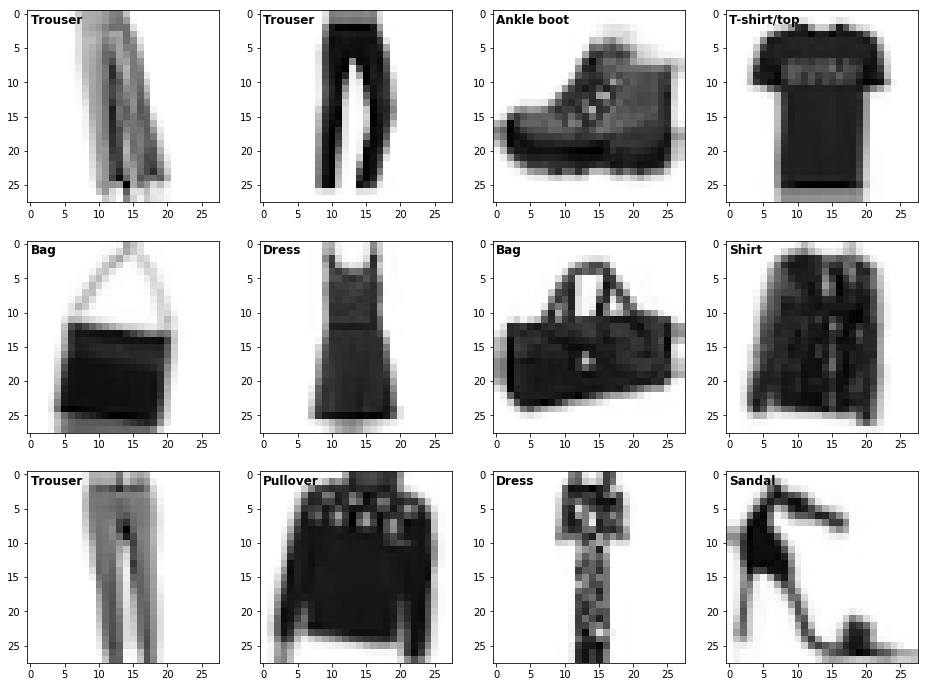

In [30]:

fig,axes=plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    ax=show_img(X[i],ax=ax)
    _=ax.text(0,0, labels[y[i]],
        verticalalignment='top', color='black', fontsize=12, weight='bold')

Validation set (no augmentation)

In [31]:
data = get_data(sz,bs)
ite = iter(data.val_dl)

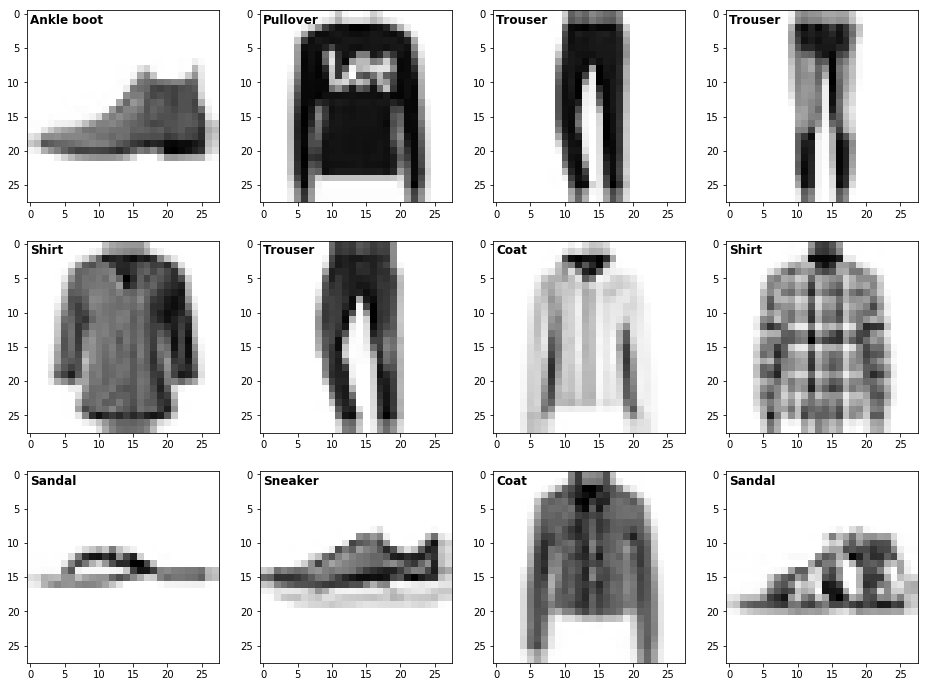

In [32]:
X,y = to_np(next(ite))
X=X[:12,0,:28,:28]
fig,axes=plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    ax=show_img(X[i],ax=ax)
    _=ax.text(0,0, labels[y[i]],
        verticalalignment='top', color='black', fontsize=12, weight='bold')

## using custom data loader

In [87]:
sz=28
bs=12

class FMNIST_3C(Dataset):
    def __init__(self,X,y,transforms=None):
        self.X = X
        self.y = y
        self.n = len(X)
        self.transforms = transforms
    
    def __getitem__(self,index):
        img = self.X[index]
        label = self.y[index]
        if self.transforms is not None:
            img = self.transforms(img)
        return (img,label)
    
    def __len__(self):
        return self.n


def get_data(bs,X,y,shuffle=True):
    X1 = gc2RGB(X)
    tsfms = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(tuple([nm_mean]*3),tuple([nm_std]*3)),
                                transforms.ToPILImage(None),
                                transforms.Pad(1),
                                transforms.RandomRotation(10),
                                transforms.ToTensor()
                               ]
                          )
    ds = FMNIST_3C(X1,y,tsfms)
    dl = DataLoader(ds,batch_size=bs,shuffle=shuffle,num_workers=0)
    
    
    return dl

In [93]:
train_dl = get_data(12,X_train,y_train)

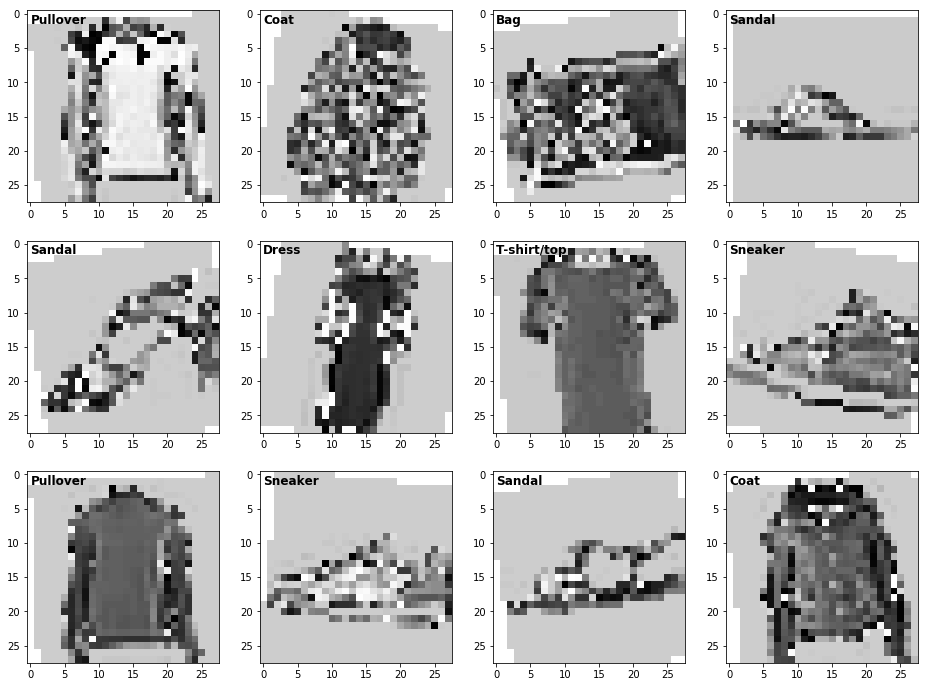

In [100]:
X,y = next(ite)
X = X.numpy()
y=y.numpy()
X=X[:12,0,:28,:28]
fig,axes=plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    ax=show_img(X[i],ax=ax)
    _=ax.text(0,0, labels[y[i]],
        verticalalignment='top', color='black', fontsize=12, weight='bold')

Those weird artifacts appear to be the result of converting to PIL and back to torch Tensor

Currently there is no easy way to do data augmentation efficiently with torchvision library. This issue has also been raised here: 

https://github.com/pytorch/vision/issues/448

# Simple NN

Using custom data loader with no data augmentation such as random rotation and cropping

In [18]:
train_ds = FMNIST(X_train,y_train,tsfms)
train_dl = DataLoader(train_ds,batch_size=32,shuffle=True,num_workers=0)
test_ds = FMNIST(X_test,y_test,tsfms)
test_dl = DataLoader(test_ds,batch_size=32,shuffle=False,num_workers=0)

In [39]:
from torch.nn.init import kaiming_uniform, kaiming_normal
class SimpleNN(nn.Module):
    def __init__(self,layers,outp,drops):
        super().__init__()
        self.weights = nn.ModuleList([nn.Linear(layers[i],layers[i+1]) for i in range(len(layers)-1)])
        self.outp = nn.Linear(layers[-1],outp)
        self.bns = nn.ModuleList([nn.BatchNorm1d(l) for l in layers[1:]])
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        
        for w in self.weights:
            kaiming_normal(w.weight.data)
        kaiming_normal(self.outp.weight.data)
    def forward(self,x):
        # flatten
        x = x.view(x.size(0),-1)
        for w,bn,dr in zip(self.weights, self.bns,self.drops):
#             x= F.relu(dr(bn(w(x))))
            x = F.relu(w(x))
#             x= F.relu(bn(w(x)))
        x = self.outp(x) # (bs,10)
        x = F.log_softmax(x,dim=-1)
        return x

In [41]:
net = SimpleNN([28*28,100],10,[.1])


In [42]:
optimizer = optim.Adam(net.parameters(),lr=0.001)

In [24]:
def train(nb_epoch):
    best=[0,100,0]
    for epoch in range(nb_epoch):
        running_trn_loss = 0.
        trn_corrects = 0
        print(f'Epoch {epoch+1}:')
        for ba in train_dl:
            inputs,labels = ba
            inputs, labels = Variable(inputs), Variable(labels)
            optimizer.zero_grad()
            #Compute the outputs given by our model at this stage.
            outputs = net(inputs)
            _,preds = torch.max(outputs.data,1)
            #Compute the loss
            loss = F.nll_loss(outputs, labels)
            running_trn_loss += loss.data[0] * inputs.size(0)
            trn_corrects += torch.sum(labels.data == preds)
            #Backpropagate the computation of the gradients
            loss.backward()
            #Do the step of the SGD
            optimizer.step()
        print(f'Training Loss: {running_trn_loss/len(train_ds)}  Accuracy: {100.*trn_corrects/len(train_ds)}')
        
        
        running_val_loss = 0.
        val_corrects = 0    
        for ba in test_dl:
            inputs,labels = ba
            inputs, labels = Variable(inputs), Variable(labels)
            outputs = net(inputs)
            _,preds = torch.max(outputs.data,1)
            #Compute the loss
            loss = F.nll_loss(outputs, labels)
            running_val_loss += loss.data[0] * inputs.size(0)
            val_corrects += torch.sum(labels.data == preds)
        print(f'Validation Loss: {running_val_loss/len(test_ds)}  Accuracy: {100.*val_corrects/len(test_ds)}')
        
        val_loss = running_val_loss/len(test_ds)
        val_acc = 100.*val_corrects/len(test_ds)
        if val_loss < best[1]:
            best[1]= val_loss
            best[2]= val_acc
            best[0] = epoch+1
    print(f'Best iteration: {best[0]} with val loss: {best[1]}, val acc: {best[2]} ')

## without batchnorm and dropout

In [32]:
train(20)

Epoch 1:
Training Loss: 0.4701891098221143  Accuracy: 83.115
Validation Loss: 0.426979985165596  Accuracy: 84.86
Epoch 2:
Training Loss: 0.3604118819355965  Accuracy: 86.88666666666667
Validation Loss: 0.37660377769470216  Accuracy: 86.48
Epoch 3:
Training Loss: 0.3251252915918827  Accuracy: 87.94666666666667
Validation Loss: 0.39630649839639664  Accuracy: 85.34
Epoch 4:
Training Loss: 0.30300698330402376  Accuracy: 88.82166666666667
Validation Loss: 0.36805234270095827  Accuracy: 87.15
Epoch 5:
Training Loss: 0.28481361074844996  Accuracy: 89.425
Validation Loss: 0.3544987232208252  Accuracy: 87.9
Epoch 6:
Training Loss: 0.2722178290585677  Accuracy: 89.84333333333333
Validation Loss: 0.3632378236413002  Accuracy: 87.49
Epoch 7:
Training Loss: 0.25797976875305173  Accuracy: 90.33
Validation Loss: 0.36197250916957857  Accuracy: 87.54
Epoch 8:
Training Loss: 0.24535473074018954  Accuracy: 90.89
Validation Loss: 0.356014321154356  Accuracy: 87.85
Epoch 9:
Training Loss: 0.238510493924220

## with bn no dropout

In [51]:
train(20)

Epoch 1:
Training Loss: 0.5020102681438128  Accuracy: 82.66833333333334
Validation Loss: 0.4268017381668091  Accuracy: 84.59
Epoch 2:
Training Loss: 0.37354170792301494  Accuracy: 86.465
Validation Loss: 0.397764958524704  Accuracy: 85.54
Epoch 3:
Training Loss: 0.3364966302990913  Accuracy: 87.735
Validation Loss: 0.38506978566646577  Accuracy: 86.09
Epoch 4:
Training Loss: 0.31336213549574216  Accuracy: 88.61166666666666
Validation Loss: 0.36150245010852816  Accuracy: 87.47
Epoch 5:
Training Loss: 0.29700259143710134  Accuracy: 89.215
Validation Loss: 0.3636846319437027  Accuracy: 87.32
Epoch 6:
Training Loss: 0.2783734321117401  Accuracy: 89.89
Validation Loss: 0.3491296519756317  Accuracy: 87.42
Epoch 7:
Training Loss: 0.2697597583323717  Accuracy: 90.09166666666667
Validation Loss: 0.3469563156604767  Accuracy: 87.79
Epoch 8:
Training Loss: 0.26066138525605204  Accuracy: 90.63833333333334
Validation Loss: 0.34567423810958864  Accuracy: 87.84
Epoch 9:
Training Loss: 0.2469634676456

## with bn + dropouts

In [36]:
train(21)

Epoch 1:
Training Loss: 0.5135111429055532  Accuracy: 82.395
Validation Loss: 0.43876418895721436  Accuracy: 84.27
Epoch 2:
Training Loss: 0.39121287387212117  Accuracy: 85.85833333333333
Validation Loss: 0.4129725981235504  Accuracy: 85.18
Epoch 3:
Training Loss: 0.356039269498984  Accuracy: 87.12
Validation Loss: 0.4003729352712631  Accuracy: 85.65
Epoch 4:
Training Loss: 0.3348866423567136  Accuracy: 87.75666666666666
Validation Loss: 0.3877351433753967  Accuracy: 85.94
Epoch 5:
Training Loss: 0.31816098250945407  Accuracy: 88.53666666666666
Validation Loss: 0.37666326681375506  Accuracy: 86.6
Epoch 6:
Training Loss: 0.3064735544085503  Accuracy: 88.695
Validation Loss: 0.3726346318721771  Accuracy: 86.73
Epoch 7:
Training Loss: 0.2937574561615785  Accuracy: 89.17
Validation Loss: 0.3658920074701309  Accuracy: 87.05
Epoch 8:
Training Loss: 0.2846807190577189  Accuracy: 89.64833333333333
Validation Loss: 0.3674471758365631  Accuracy: 86.9
Epoch 9:
Training Loss: 0.2740944677670797  A

Beside regularization from Adam optimizer, extra regularization (bn and drop out) does not work that well for such small dataset

# Learning rate finder

Source : https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

The idea is to use a small learning rate (10^-8) and for each minibatch, increase it by multiplying by some factor. We record loss for each learning rate and plot the loss function with respect to learning rate, in log scale. 

In [21]:
len(train_dl)

1875

In [44]:
net

SimpleNN(
  (weights): ModuleList(
    (0): Linear(in_features=784, out_features=100, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=100, out_features=10, bias=True)
  (drops): ModuleList(
    (0): Dropout(p=0.1)
  )
)

In [72]:
import math
def find_lr(lr_start = 1e-8,lr_end=10, beta = .95):
    num = len(train_dl) # number of steps (minibatch) 
    mult = (lr_end / lr_start) ** (1/num)
    lr = lr_start
    optimizer.param_groups[0]['lr'] = lr # set lr for optimizer
    avg_loss = 0. # old avg loss
    best_loss = 0. #lowest loss. Used for stopping when loss starts to explode: 
    # current smoothed loss > 4 * minimum smoothed loss
    batch_num = 0
    
    # for plotting
    losses = []
    log_lrs = []
    for data in train_dl:
        batch_num += 1
        #As before, get the loss for this mini-batch of inputs/outputs
        inputs,labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = F.nll_loss(outputs, labels)
        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) *loss.data[0] # exp weighted averages on log loss
        smoothed_loss = avg_loss / (1 - beta**batch_num) # bias-corrected of exp weighted averages
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        #Store the values
        losses.append(smoothed_loss)
        
        #taking log lr to have evenly spaced points on the plotted curve
        log_lrs.append(math.log10(lr))
        
        #Do the SGD step
        loss.backward()
        optimizer.step()
        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses

## Test with SGD optimizer

In [77]:
net = SimpleNN([28*28,100],10,[.1])
optimizer = optim.SGD(net.parameters(),lr=0.001)

In [78]:
log_lrs,losses = find_lr()

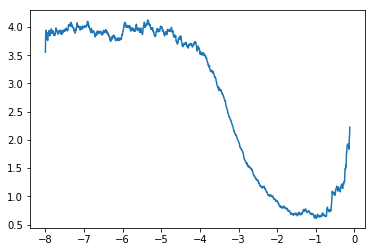

In [79]:
plt.plot(log_lrs,losses)

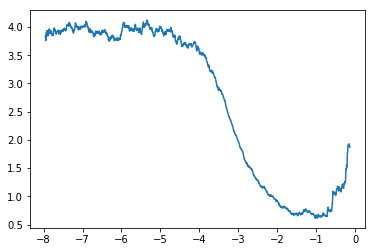

In [80]:
plt.plot(log_lrs[10:-5],losses[10:-5])

In [94]:
net = SimpleNN([28*28,100],10,[.1])
optimizer = optim.SGD(net.parameters(),lr=0.05)

In [95]:
train(5)

Epoch 1:
Training Loss: 0.4815035904288292  Accuracy: 82.77166666666666
Validation Loss: 0.42095525534152983  Accuracy: 84.96
Epoch 2:
Training Loss: 0.36804150743087133  Accuracy: 86.62166666666667
Validation Loss: 0.3863409427881241  Accuracy: 85.76
Epoch 3:
Training Loss: 0.33324395702878634  Accuracy: 87.895
Validation Loss: 0.3711943527460098  Accuracy: 86.72
Epoch 4:
Training Loss: 0.3106721770465374  Accuracy: 88.725
Validation Loss: 0.36010925846099856  Accuracy: 87.12
Epoch 5:
Training Loss: 0.293251091097792  Accuracy: 89.34666666666666
Validation Loss: 0.35338898152112963  Accuracy: 87.08
Best iteration: 5 with val loss: 0.35338898152112963, val acc: 87.08 


In [93]:
net = SimpleNN([28*28,100],10,[.1])
optimizer = optim.SGD(net.parameters(),lr=10**-1)

train(5)

Epoch 1:
Training Loss: 0.47229704044262566  Accuracy: 82.91333333333333
Validation Loss: 0.4190855041027069  Accuracy: 84.87
Epoch 2:
Training Loss: 0.36162473235527676  Accuracy: 86.83833333333334
Validation Loss: 0.40521939635276794  Accuracy: 85.65
Epoch 3:
Training Loss: 0.3273186469376087  Accuracy: 88.07833333333333
Validation Loss: 0.3733721847772598  Accuracy: 86.89
Epoch 4:
Training Loss: 0.3034215909818808  Accuracy: 88.92833333333333
Validation Loss: 0.3651914852142334  Accuracy: 86.9
Epoch 5:
Training Loss: 0.28775047983924545  Accuracy: 89.315
Validation Loss: 0.3698055908083916  Accuracy: 86.94
Best iteration: 4 with val loss: 0.3651914852142334, val acc: 86.9 


Selecting minimum learning rate (0.1) based on LR finder results in a worse validation loss since LR here is still high and loss is on the verge of increasing. A LR lower than it (in this case it's 0.03 or 10^-1.5) is more safe and effective

## Adam

In [86]:
net = SimpleNN([28*28,100],10,[.1])
optimizer = optim.Adam(net.parameters(),lr=0.001)

In [87]:
log_lrs,losses = find_lr()

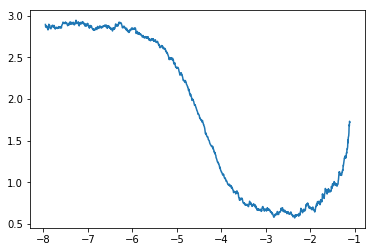

In [88]:
plt.plot(log_lrs[10:-5],losses[10:-5])

In [97]:
net = SimpleNN([28*28,100],10,[.1])
optimizer = optim.Adam(net.parameters(),lr=10**-3)

train(5)

Epoch 1:
Training Loss: 0.46227240395943325  Accuracy: 83.28
Validation Loss: 0.40756298243999484  Accuracy: 85.28
Epoch 2:
Training Loss: 0.3565093750715256  Accuracy: 86.95333333333333
Validation Loss: 0.39446539452075957  Accuracy: 85.44
Epoch 3:
Training Loss: 0.3195662118256092  Accuracy: 88.16333333333333
Validation Loss: 0.39533088693618773  Accuracy: 86.07
Epoch 4:
Training Loss: 0.3002463410238425  Accuracy: 88.87833333333333
Validation Loss: 0.36748897948265075  Accuracy: 86.55
Epoch 5:
Training Loss: 0.28221147474249203  Accuracy: 89.50666666666666
Validation Loss: 0.3491303251862526  Accuracy: 87.34
Best iteration: 5 with val loss: 0.3491303251862526, val acc: 87.34 
